In [1]:
import sys
from pathlib import Path

import cv2
import torch
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

sys.path.append('..')
from src.segmentation.dl import Segmentator
from src.segmentation.dlSrc.models import linknet
from src.segmentation.dlSrc.dataset import get_preprocessing

In [137]:
data_dir = Path('/home/vladbakhteev/data/aorta/')

img_path = data_dir / 'imageCT_005.nii'
mask_path = data_dir / 'result5.nii'

path_to_weights = '../weights/_ckpt_epoch_49.ckpt'


def load_array(p):
    img = nib.load(p)
    img = np.asanyarray(img.dataobj)
    return img

img3d = load_array(img_path)
mask3d = load_array(mask_path)

img3d.shape

(487, 487, 1278)

In [138]:
model = linknet(encoder_name='efficientnet-b0', encoder_depth=5, in_channels=3, classes=1)
model = Segmentator.load_from_checkpoint(path_to_weights, model=model)
model.eval()

Segmentator(
  (model): Linknet(
    (encoder): EfficientNetEncoder(
      (_conv_stem): Conv2dStaticSamePadding(
        3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
        (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
      )
      (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_blocks): ModuleList(
        (0): MBConvBlock(
          (_depthwise_conv): Conv2dStaticSamePadding(
            32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
            (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
          )
          (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (_se_reduce): Conv2dStaticSamePadding(
            32, 8, kernel_size=(1, 1), stride=(1, 1)
            (static_padding): Identity()
          )
          (_se_expand): Conv2dStaticSamePadding(
            8, 32, kernel_size=(1, 1), stride=(

In [157]:
i = 1100

img2d = img3d[:, :, i-1:i+2]
mask2d = mask3d[:, :, i]

preprocessing = get_preprocessing(size=320)
img_tensor = preprocessing(image=img2d)['image'].unsqueeze(0).float()

with torch.no_grad():
    prediction = model(img_tensor).squeeze().sigmoid()
    prediction = (prediction > 0.5).float() * 1
    prediction = prediction.numpy()

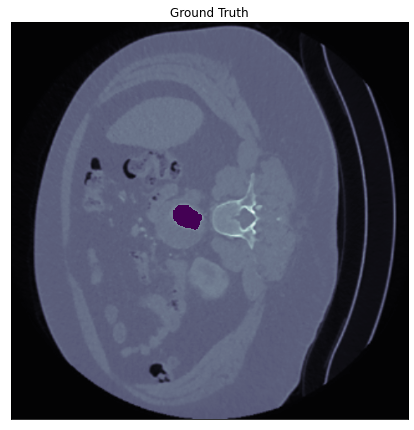

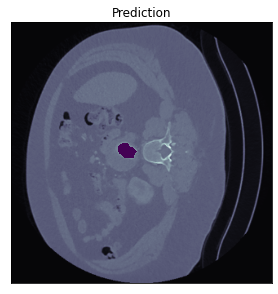

In [158]:
def single_2d_plot(img, mask=None, aspect=1.0, title=''):
    img = cv2.resize(img, mask.shape)
    vmin=img.min()
    vmax=img.max()
    figsize = (0.015 * img.shape[1], 0.015 * img.shape[0])
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xticks([])
    ax.set_yticks([])

    plt.imshow(img, cmap=plt.cm.bone, vmin=vmin, vmax=vmax)
    ax.set_aspect(aspect)

    if mask is not None:
        mask = np.ma.masked_where(mask == 0, mask)
        plt.imshow(mask, alpha=1., cmap='viridis')

    plt.plot()
    plt.title(title)

img2d = img_tensor[0][1].numpy()
single_2d_plot(img2d, mask=mask2d, title='Ground Truth')
single_2d_plot(img2d, mask=prediction, title='Prediction')